# *Outlines*

1: Loading 10-minute statistics of Preprocessed SCADA data

2: Plotting various SCADA parameters

3: Training a Neural Network with pre-defined architecture to predict Load


# **Introduction**

This workshop utilizes open source data from [Aventa AV-7 (6kW) IET-OST Research Wind Turbine SCADA](https://zenodo.org/records/17362783). The original dataset is 1Hz SCADA but is preprocessed in 10 minute SCADA statistics.

# *Loading Necessary Packages*

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Packages for handling and processing load data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Loading Data

In [5]:
data_path = os.path.join(os.getcwd(),'AV-7-10min-Data.parquet')
df = pd.read_parquet(data_path)

In [6]:
df

,rotor_speed-mean,rotor_speed-std,generator_speed-mean,generator_speed-std,generator_temperature-mean,generator_temperature-std,wind_speed-mean,wind_speed-std,power_output-mean,power_output-std,relative_wind_direction-mean,relative_wind_direction-std,blade_pitch_deg-mean,blade_pitch_deg-std
datetime,,,,,,,,,,,,,,
2025-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,6.727365,0.143893,1.600676,0.357373,0.000000,0.000000,-17.344595,16.689648,38.191855,0.0
2025-01-01 00:10:00,0.000000,0.000000,0.000000,0.000000,5.507227,0.169466,0.843529,0.453795,0.000000,0.000000,22.421849,42.560615,38.191855,0.0
2025-01-01 00:20:00,0.000000,0.000000,0.000000,0.000000,5.100671,0.008172,0.650168,0.367572,0.000000,0.000000,-11.436242,43.325591,38.191855,0.0
2025-01-01 00:30:00,0.000000,0.000000,0.000000,0.000000,5.100000,0.000000,0.857358,0.476135,0.000000,0.000000,-30.479933,16.536506,38.191855,0.0
2025-01-01 00:40:00,0.000000,0.000000,0.000000,0.000000,4.745059,0.371235,0.303350,0.380818,0.000000,0.000000,-19.075377,38.734200,38.191855,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-09 12:40:00,50.984975,4.233807,617.263773,45.711439,34.957930,0.887369,3.665609,0.400525,3.065159,0.825066,-9.375626,9.676237,14.034000,0.0
2025-05-09 12:50:00,42.298829,6.792252,520.538462,77.421086,35.555686,0.641574,3.044147,0.524340,1.725251,0.803330,-0.130435,17.377079,14.034000,0.0
2025-05-09 13:00:00,30.985643,3.338324,389.938230,39.031689,32.861603,0.481144,2.320701,0.409591,0.489750,0.231132,-3.681135,23.353618,14.034000,0.0


# Define damage function 

In [5]:
def damage_func(row,
                v_cut=25.0,        # ~ cut-out wind speed [m/s]
                power_ref=3000.0,  # ~ rated power [kW], change if needed
                rotor_ref=20.0,    # ~ rated rotor speed [rpm]
                temp_ref=60.0):    # ref generator temp [°C]
    # --- raw inputs ---
    v      = row['wind_speed-mean']
    v_std  = row['wind_speed-std']
    P      = row['power_output-mean']          # in kW (adjust if you use MW)
    rotor  = row['rotor_speed-mean']
    yaw    = row['relative_wind_direction-mean']   # deg
    pitch  = row['blade_pitch_deg-mean']           # deg
    T      = row['generator_temperature-mean']

    # --- simple normalizations (clipped) ---
    v_n     = np.clip(v / v_cut, 0.0, 2.0)        # allow up to 2x for storms
    P_n     = np.clip(P / power_ref, 0.0, 2.0)
    rotor_n = np.clip(rotor / rotor_ref, 0.0, 2.0)
    yaw_n   = np.clip(abs(yaw) / 45.0, 0.0, 2.0)  # 45° misalignment ~ 1
    pitch_n = np.clip(pitch / 80.0, 0.0, 2.0)     # 80° ~ feathered

    # --- helper: smooth indicators ---
    def sigmoid(x):
        return 1.0 / (1.0 + np.exp(-x))

    # operating: high when power is non-zero
    I_op = sigmoid(5.0 * (P_n - 0.05))

    # parked in high wind: high wind but not producing
    I_park = sigmoid((v - 10.0) / 2.0) * (1.0 - I_op)

    # --- base load term (always present) ---
    base = (
        0.2
        + 1.0 * (v_n**2)
        + 0.7 * (P_n**2)
        + 0.3 * (rotor_n**2)
    )

    # --- yaw misalignment term (only relevant in operation) ---
    yaw_term = 0.5 * (yaw_n**2) * v_n * I_op

    # --- parked high-wind term ---
    # more damage if high wind, pitched & parked
    park_term = 1.2 * I_park * (v_n**2) * (0.5 + 0.5 * pitch_n)

    # --- temperature penalty (only when operating) ---
    over_temp = np.maximum(0.0, (T - temp_ref) / 20.0)  # 20°C above ref → 1
    temp_term = 0.3 * (over_temp**2) * I_op

    # --- total synthetic damage ---
    D = base + yaw_term + park_term + temp_term

    return D



# Neural Network Model

In [6]:
class DamageMLP(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        # self.norm = Normalization(mean, std)
        self.net = nn.Sequential(
            nn.Linear(in_features, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        # x = self.norm(x)
        return self.net(x)

In [7]:
# -----------------------------
# 1) Prepare data
# -----------------------------
feature_cols = df.columns.tolist()
df['damage'] = df.apply(damage_func, axis=1) 
#df['damage'].describe()

X = df[feature_cols].values.astype('float32')
y = df['damage'].values.astype('float32').reshape(-1, 1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -----------------------------
# 2) Normalization of input features
# -----------------------------
mean = X_train.mean(axis=0)
std  = X_train.std(axis=0) + 1e-8   # avoid division by zero
X_train = (X_train - mean) / std
X_test  = (X_test - mean) / std

# mean_t = torch.tensor(mean, dtype=torch.float32)
# std_t  = torch.tensor(std, dtype=torch.float32)

# -----------------------------
# 3) Datasets & loaders
# -----------------------------

X_train_t = torch.from_numpy(X_train)
y_train_t = torch.from_numpy(y_train)
X_test_t  = torch.from_numpy(X_test)
y_test_t  = torch.from_numpy(y_test)

train_ds = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)

# -----------------------------
# 4) Build NN model
# -----------------------------
model = DamageMLP(X_train.shape[1])

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

# -----------------------------
# 5) Training loop
# -----------------------------
n_epochs = 100

for epoch in range(1, n_epochs + 1):
    # ---- train ----
    model.train()
    train_loss = 0.0
    
    for xb, yb in train_loader:
        
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * xb.size(0)
    
    train_loss /= len(train_ds)

    if epoch == 1 or epoch % 10 == 0:
        print(f"Epoch {epoch:3d} | Train MSE: {train_loss:.4e}")


Epoch   1 | Train MSE: 6.7270e-02
Epoch  10 | Train MSE: 1.3372e-02
Epoch  20 | Train MSE: 1.1769e-02
Epoch  30 | Train MSE: 1.0407e-02
Epoch  40 | Train MSE: 1.0751e-02
Epoch  50 | Train MSE: 9.9853e-03
Epoch  60 | Train MSE: 1.1462e-02
Epoch  70 | Train MSE: 1.0122e-02
Epoch  80 | Train MSE: 9.7167e-03
Epoch  90 | Train MSE: 7.7009e-03
Epoch 100 | Train MSE: 8.5840e-03


# Evaluate the model on the test (unseen) data

tensor([1.0480]) tensor([1.0595])
tensor([0.2114]) tensor([0.2119])
tensor([0.2049]) tensor([0.2040])
tensor([0.3652]) tensor([0.3641])
tensor([0.2002]) tensor([0.2017])
tensor([1.4146]) tensor([1.4244])
tensor([1.4187]) tensor([1.4150])
tensor([1.4313]) tensor([1.4312])
tensor([0.1996]) tensor([0.2000])
tensor([0.1996]) tensor([0.2001])


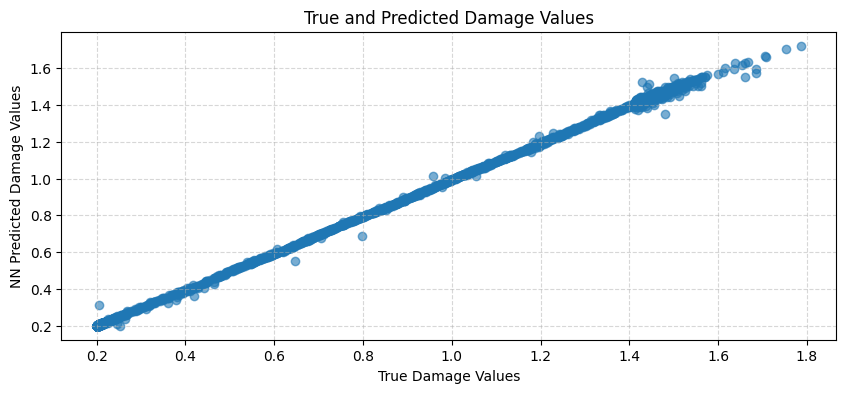

In [8]:
# run predictions on test data
model.eval()
with torch.no_grad():
    preds = model(X_test_t)

# print results
for i in range(10):
    print(preds[i],y_test_t[i])

# plot results
plt.figure(figsize=(10, 4))
plt.scatter(y_test_t, preds.numpy(), alpha=0.6)
plt.xlabel('True Damage Values')
plt.ylabel('NN Predicted Damage Values')
plt.title('True and Predicted Damage Values')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [ ]:
## mimic the story of curtailment -- in the power curve -- break the power curve to have a curtailment condition>>
## the idea of hallucination for prediction on data not contained in the training set (unseen data)
## plots on time vs damage (predicted or actual) seen versus unseen data! on a timescale
